In [44]:
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import OneHotEncoder,StandardScaler
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score,f1_score,classification_report
import category_encoders as ce
from sklearn.model_selection import StratifiedKFold, cross_validate,TimeSeriesSplit
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

In [2]:
full_train=pd.read_parquet("../data/processed/full_train.parquet")
full_priors=pd.read_parquet("../data/processed/full_priors.parquet")

In [3]:
orders=pd.read_csv("../data/raw/orders.csv")

we will use full_priors for feature engineering since it has the prior orders for each user and then merge full_train with these features for modeling

## User-level features

In [4]:
total_orders=full_priors.groupby('user_id')['order_id'].nunique().rename('total_orders').reset_index()
avg_basket_size=full_priors.groupby(['user_id','order_id']).size().groupby('user_id').mean().rename('avg_basket_size').reset_index()
reorder_ratio=full_priors.groupby('user_id')['reordered'].mean().rename("reorder_ratio").reset_index()
mean_days_between_orders=full_priors.groupby('user_id')['days_since_prior_order'].mean().rename('mean_days_between_orders').reset_index()
last_order_recency=full_priors.sort_values(['user_id', 'order_number']).groupby('user_id')['days_since_prior_order'].last().rename('last_order_recency').reset_index()

user_fet=(total_orders.merge(avg_basket_size, on='user_id', how='left').merge(reorder_ratio, on='user_id', how='left')
              .merge(mean_days_between_orders, on='user_id', how='left').merge(last_order_recency, on='user_id', how='left'))
user_fet.head()

,user_id,total_orders,avg_basket_size,reorder_ratio,mean_days_between_orders,last_order_recency
0,1,10,5.900000,0.694915,18.542374,30.0
1,2,14,13.928571,0.476923,14.902564,13.0
2,3,12,7.333333,0.625000,10.181818,15.0
3,4,5,3.600000,0.055556,11.944445,0.0
4,5,4,9.250000,0.378378,10.189189,19.0


## Product-level features

In [5]:
product_reorder_rate=full_priors.groupby('product_id')['reordered'].mean().rename('product_reorder_rate').reset_index()
avg_pos_in_cart=full_priors.groupby('product_id')['add_to_cart_order_winsor'].mean().rename('avg_pos_in_cart').reset_index()
product_avg_order=full_priors.groupby("product_id")['order_number'].mean().rename('product_popularity').reset_index() # product popularity

product_fet=product_reorder_rate.merge(avg_pos_in_cart,on='product_id',how='left').merge(product_avg_order,on='product_id',how='left')
product_fet.head()

,product_id,product_reorder_rate,avg_pos_in_cart,product_popularity
0,1,0.613391,5.673866,19.397408
1,2,0.133333,9.455556,25.666667
2,3,0.732852,6.176895,17.342960
3,4,0.446809,9.246201,9.027356
4,5,0.600000,6.466667,8.933333


## User×Product interaction features

In [6]:
prior_purchase_count=full_priors.groupby(['user_id','product_id']).size().rename('prior_purchase_count').reset_index()
days_since_last_purchase=(full_priors.sort_values(['user_id','product_id','order_number']).groupby(['user_id','product_id'])['days_since_prior_order']
                          .last().rename("days_since_last_purchase").reset_index())
avg_reorder_prob=full_priors.groupby(['user_id','product_id'])['reordered'].mean().rename('avg_reorder_prob').reset_index()

user_product_fet=prior_purchase_count.merge(days_since_last_purchase,on=['user_id','product_id'],how='left').merge(avg_reorder_prob,on=['user_id','product_id'],how='left')
user_product_fet.head()
                  

,user_id,product_id,prior_purchase_count,days_since_last_purchase,avg_reorder_prob
0,1,196,10,30.0,0.900000
1,1,10258,9,30.0,0.888889
2,1,10326,1,28.0,0.000000
3,1,12427,10,30.0,0.900000
4,1,13032,3,30.0,0.666667


## Temporal features

In [7]:
full_train['is_morning']=full_train['order_hour_of_day'].between(5, 11).astype(int)
full_train['is_afternoon']=full_train['order_hour_of_day'].between(12, 16).astype(int)
full_train['is_evening']=full_train['order_hour_of_day'].between(17, 20).astype(int)
full_train['is_night']=(~full_train['order_hour_of_day'].between(5, 20)).astype(int)

## Aggregations Over Windows
Average reorder rate over the user’s last 3 purchased products

In [8]:
last_3=full_priors.sort_values(['user_id','order_number']).groupby('user_id').tail(3)
avg_basket_size_last3 = last_3.groupby('user_id')['order_id'].nunique().rename('avg_basket_size_last3').reset_index()
mean_days_last3=last_3.groupby('user_id')['days_since_prior_order'].mean().rename('mean_days_last3').reset_index()

## Log Transforms
Log transformations were applied selectively to highly skewed count-based and continuous features.

In [9]:
user_fet.skew()

user_id                     0.000000
total_orders                2.400456
avg_basket_size             1.230259
reorder_ratio               0.034879
mean_days_between_orders    0.246687
last_order_recency          0.192300
dtype: float64

We used log1p instead of log to handle zero values

Text(0.5, 1.0, 'Distribution of Total Orders\n(after log1p)')

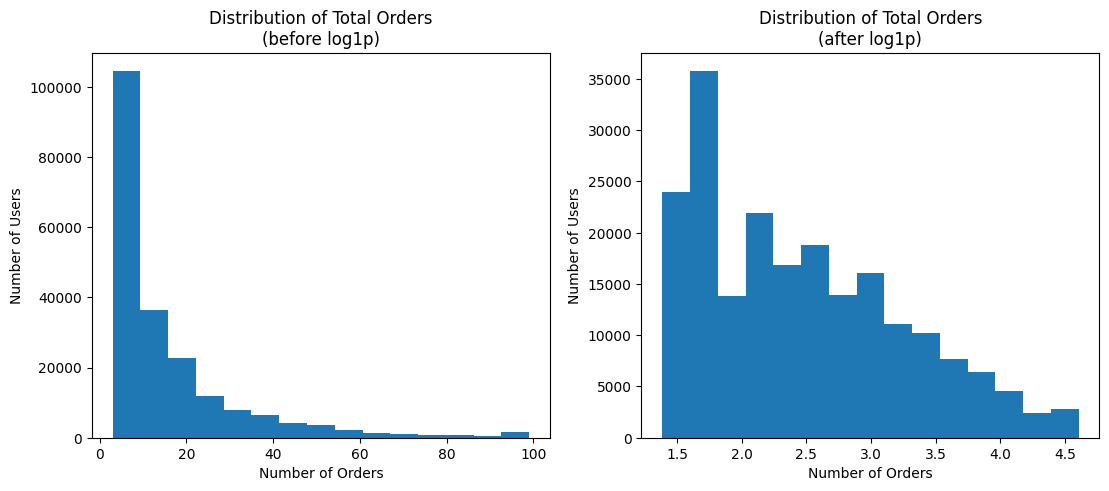

In [10]:
fig,axes=plt.subplots(1,2,figsize=(13,5))

axes[0].hist(user_fet['total_orders'],bins=15)
axes[0].set_xlabel('Number of Orders')
axes[0].set_ylabel('Number of Users')
axes[0].set_title('Distribution of Total Orders\n(before log1p)')

user_fet['total_orders_log']=np.log1p(user_fet['total_orders'])

axes[1].hist(user_fet['total_orders_log'],bins=15)
axes[1].set_xlabel('Number of Orders')
axes[1].set_ylabel('Number of Users')
axes[1].set_title('Distribution of Total Orders\n(after log1p)')

In [11]:
user_product_fet.skew()

user_id                     0.005730
product_id                 -0.033893
prior_purchase_count        5.998498
days_since_last_purchase    0.752069
avg_reorder_prob            0.665549
dtype: float64

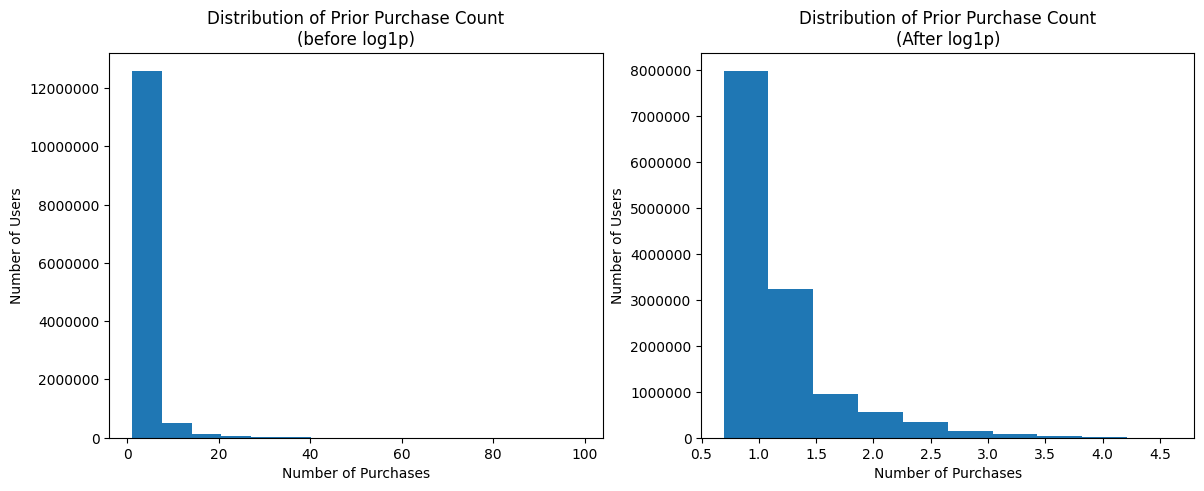

In [12]:
fig,axes=plt.subplots(1,2,figsize=(14,5))

axes[0].hist(user_product_fet['prior_purchase_count'],bins=15)
axes[0].set_xlabel('Number of Purchases')
axes[0].set_ylabel('Number of Users')
axes[0].set_title('Distribution of Prior Purchase Count\n(before log1p)')
axes[0].ticklabel_format(style='plain')

user_product_fet['prior_purchase_count_log']=np.log1p(user_product_fet['prior_purchase_count'])

axes[1].hist(user_product_fet['prior_purchase_count_log'])
axes[1].set_xlabel('Number of Purchases')
axes[1].set_ylabel('Number of Users')
axes[1].set_title('Distribution of Prior Purchase Count\n(After log1p)')
axes[1].ticklabel_format(style='plain')


In [13]:
reg_df=orders.merge(user_fet,on='user_id',how='left').merge(avg_basket_size_last3,on='user_id',how='left').merge(mean_days_last3,on='user_id',how='left')
reg_df=reg_df.drop('reorder_ratio',axis=1)
reg_df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,total_orders,avg_basket_size,mean_days_between_orders,last_order_recency,total_orders_log,avg_basket_size_last3,mean_days_last3
0,2539329,1,prior,1,2,8,NaN,10,5.9,18.542374,30.0,2.397895,1,30.0
1,2398795,1,prior,2,3,7,15.0,10,5.9,18.542374,30.0,2.397895,1,30.0
2,473747,1,prior,3,3,12,21.0,10,5.9,18.542374,30.0,2.397895,1,30.0
3,2254736,1,prior,4,4,7,29.0,10,5.9,18.542374,30.0,2.397895,1,30.0
4,431534,1,prior,5,4,15,28.0,10,5.9,18.542374,30.0,2.397895,1,30.0


In [14]:
reg_df['days_since_prior_order']=reg_df['days_since_prior_order'].fillna(0)

In [15]:
orders= orders.sort_values(['user_id', 'order_number'])

orders['days_until_next_order'] = (
    orders.groupby('user_id')['days_since_prior_order']
    .shift(-1)
)

orders = orders.dropna(subset=['days_until_next_order'])


## Merging full_train with engineered features

In [16]:
full_train=(full_train.merge(user_fet,on='user_id',how='left').merge(product_fet,on='product_id',how='left')
            .merge(user_product_fet,on=['user_id','product_id'],how='left').merge(avg_basket_size_last3,on='user_id',how='left')
            .merge(mean_days_between_orders,on='user_id',how='left'))
full_train.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,...,total_orders_log,product_reorder_rate,avg_pos_in_cart,product_popularity,prior_purchase_count,days_since_last_purchase,avg_reorder_prob,prior_purchase_count_log,avg_basket_size_last3,mean_days_between_orders_y
0,1,49302,1,1,112108,train,4,4,10,9.0,...,1.386294,0.619632,6.361963,19.625767,2.0,7.0,0.5,1.098612,1,6.238095
1,1,11109,2,1,112108,train,4,4,10,9.0,...,1.386294,0.713775,7.208855,18.642665,2.0,7.0,0.5,1.098612,1,6.238095
2,1,10246,3,0,112108,train,4,4,10,9.0,...,1.386294,0.524553,9.243809,19.814572,NaN,NaN,NaN,NaN,1,6.238095
3,1,49683,4,0,112108,train,4,4,10,9.0,...,1.386294,0.691702,7.507157,14.919529,NaN,NaN,NaN,NaN,1,6.238095
4,1,43633,5,1,112108,train,4,4,10,9.0,...,1.386294,0.477795,8.777948,14.926493,2.0,15.0,0.5,1.098612,1,6.238095


In [17]:
full_train.isna().sum()[full_train.isna().sum()>0]

product_reorder_rate             9
avg_pos_in_cart                  9
product_popularity               9
prior_purchase_count        555793
days_since_last_purchase    555793
avg_reorder_prob            555793
prior_purchase_count_log    555793
dtype: int64

missing values appeared because some users,products weren't in full_priors so missing values were filled with zero, indicating the absence of prior data 

In [18]:
full_train[['prior_purchase_count_log','avg_pos_in_cart','product_popularity']]=full_train[['prior_purchase_count_log','avg_pos_in_cart','product_popularity']].fillna(0)
full_train['days_since_last_purchase'] = full_train['days_since_last_purchase'].fillna(-1)
print('Number of Missing Values:',full_train.isna().sum().sum())

Number of Missing Values: 1111595


## Dropping Columns That We Won't Be Used Further (Redundant/leakage/meaningless).

In [19]:
col_to_drop=['product_name','product_reorder_rate','avg_reorder_prob','is_first_order','mean_days_between_orders_y',
               'eval_set','add_to_cart_order','aisle','department_id','reorder_ratio','total_orders','prior_purchase_count',    
               'days_since_last_purchase','prior_purchase_count_log']

full_train=full_train.drop(columns=col_to_drop)
full_train.head(10)

,order_id,product_id,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle_id,department,...,is_afternoon,is_evening,is_night,avg_basket_size,mean_days_between_orders_x,last_order_recency,total_orders_log,avg_pos_in_cart,product_popularity,avg_basket_size_last3
0,1,49302,1,112108,4,4,10,9.0,120,dairy eggs,...,0,0,0,7.0,6.238095,15.0,1.386294,6.361963,19.625767,1
1,1,11109,1,112108,4,4,10,9.0,108,dairy eggs,...,0,0,0,7.0,6.238095,15.0,1.386294,7.208855,18.642665,1
2,1,10246,0,112108,4,4,10,9.0,83,produce,...,0,0,0,7.0,6.238095,15.0,1.386294,9.243809,19.814572,1
3,1,49683,0,112108,4,4,10,9.0,83,produce,...,0,0,0,7.0,6.238095,15.0,1.386294,7.507157,14.919529,1
4,1,43633,1,112108,4,4,10,9.0,95,canned goods,...,0,0,0,7.0,6.238095,15.0,1.386294,8.777948,14.926493,1
5,1,13176,0,112108,4,4,10,9.0,24,produce,...,0,0,0,7.0,6.238095,15.0,1.386294,5.035154,20.463315,1
6,1,47209,0,112108,4,4,10,9.0,24,produce,...,0,0,0,7.0,6.238095,15.0,1.386294,6.653317,19.420443,1
7,1,22035,1,112108,4,4,10,9.0,21,dairy eggs,...,0,0,0,7.0,6.238095,15.0,1.386294,7.883973,19.942456,1
8,36,39612,0,79431,23,6,18,30.0,2,dairy eggs,...,0,1,0,8.5,16.352942,30.0,3.135494,9.434066,17.995879,1
9,36,19660,1,79431,23,6,18,30.0,115,beverages,...,0,1,0,8.5,16.352942,30.0,3.135494,4.477562,18.661704,1


In [20]:
df=full_train.sort_values('order_id').reset_index(drop=True)
split=int(len(df)*0.8)
df_train=df.iloc[:split]
df_val=df.iloc[split:]

In [21]:
X_train=df_train.drop(columns=['reordered','order_id'],axis=1)
y_train=df_train['reordered']

X_val=df_val.drop(columns=['reordered','order_id'],axis=1)
y_val=df_val['reordered']

## Encoding Comparision

In [22]:
df.nunique()

order_id                      131209
product_id                     39123
reordered                          2
user_id                       131209
order_number                      97
order_dow                          7
order_hour_of_day                 24
days_since_prior_order            31
aisle_id                         134
department                        21
add_to_cart_order_winsor          23
is_morning                         2
is_afternoon                       2
is_evening                         2
is_night                           2
avg_basket_size                15106
mean_days_between_orders_x     73057
last_order_recency                31
total_orders_log                  97
avg_pos_in_cart                24876
product_popularity             28764
avg_basket_size_last3              3
dtype: int64

In [23]:
low_card=['order_dow','department']
high_cat=['user_id', 'product_id'] 
num_col=list(X_train.drop(low_card+high_cat,axis=1))


In [24]:
preprocess_ohe=ColumnTransformer(transformers=[('onehot',OneHotEncoder(handle_unknown='ignore'),low_card),
                                               ('scaler',StandardScaler(),num_col)],remainder='drop')

ohe_pipline=Pipeline(steps=[('preprocess',preprocess_ohe),
                            ('model',LogisticRegression())])
ohe_pipline

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('onehot', ...), ('scaler', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [25]:
ohe_pipline.fit(X_train, y_train)
y_pred=ohe_pipline.predict_proba(X_val)[:, 1]
roc_auc_ohe=roc_auc_score(y_val, y_pred)
avg_pr_ohe=average_precision_score(y_val, y_pred)

roc_auc_ohe, avg_pr_ohe

(0.7531516790429995, 0.8096078087312258)

In [26]:
preprocess_target=ColumnTransformer(transformers=[('te',ce.TargetEncoder(cols=high_cat,smoothing=10),high_cat),
                                                  ('onehot',OneHotEncoder(handle_unknown='ignore'),low_card),
                                                  ('num',StandardScaler(),num_col)],remainder='drop')

target_pipline=Pipeline(steps=[('preprocess',preprocess_target),
                                ('model',LogisticRegression())])
target_pipline

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('te', ...), ('onehot', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [27]:
cv=TimeSeriesSplit(n_splits=5)
scores=cross_validate(
    target_pipline,
    X_train, y_train,
    cv=cv,
    scoring={"roc_auc": "roc_auc", "avg_pr": "average_precision"},
    n_jobs=-1
)
float(scores["test_roc_auc"].mean()),float(scores["test_avg_pr"].mean())

(0.7183730796320947, 0.788688841941533)

In [28]:
target_pipline.fit(X_train, y_train)
proba=target_pipline.predict_proba(X_val)[:, 1]
roc_auc_target=roc_auc_score(y_val, proba)
avg_pr_target=average_precision_score(y_val, proba)
(roc_auc_target,avg_pr_target)

(0.7258315405062059, 0.7946797356002953)

In [29]:
preprocess_frequency=ColumnTransformer(transformers=[('freq',ce.CountEncoder(cols=high_cat,normalize=True),high_cat),
                                                     ('onehot',OneHotEncoder(handle_unknown='ignore'),low_card),
                                                     ('num',StandardScaler(),num_col)],remainder='drop')
frequency_pipline=Pipeline(steps=[('preprocess',preprocess_frequency),
                                  ('model',LogisticRegression(max_iter=5000))])
frequency_pipline

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('freq', ...), ('onehot', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [30]:
frequency_pipline.fit(X_train,y_train)
proba=frequency_pipline.predict_proba(X_val)[:,1]
roc_auc_freq=roc_auc_score(y_val,proba)
avg_pr_freq=average_precision_score(y_val,proba)

(roc_auc_freq,avg_pr_freq)

(0.7531671149531276, 0.8096086633156858)

In [31]:
results=pd.DataFrame({'roc_auc':[roc_auc_ohe,roc_auc_target,roc_auc_freq],
                      'avg_pr_score':[avg_pr_ohe,avg_pr_target,avg_pr_freq]},index=['OneHotEnc','TargetEnc','FrequencyEnc'])
results

,roc_auc,avg_pr_score
OneHotEnc,0.753152,0.809608
TargetEnc,0.725832,0.794680
FrequencyEnc,0.753167,0.809609


## Classification

In [32]:
df_train=df_train.drop(columns=['user_id','product_id','order_id'])
df_val=df_val.drop(columns=['user_id','product_id','order_id'])

X_train=df_train.drop(columns=['reordered'],axis=1)
y_train=df_train['reordered']

X_val=df_val.drop(columns=['reordered'],axis=1)
y_val=df_val['reordered']

In [37]:
df_train['reordered'].value_counts()

reordered
1    663016
0    444677
Name: count, dtype: int64

In [ ]:
ct=ColumnTransformer(transformers=[('onehot',OneHotEncoder(handle_unknown='ignore'),low_card),
                                   ('scaler',StandardScaler(),num_col)],remainder='drop')
base_pipline=Pipeline(steps=[('preprocess',ct),
                             ('model',LogisticRegression())])
base_pipline.fit(X_train,y_train)
y_pred_base=base_pipline.predict(X_val)
f1_base=f1_score(y_val,y_pred_base)
print(classification_report(y_val,y_pred_base))

              precision    recall  f1-score   support

           0       0.65      0.53      0.59    111116
           1       0.72      0.81      0.76    165808

    accuracy                           0.70    276924
   macro avg       0.69      0.67      0.68    276924
weighted avg       0.69      0.70      0.69    276924



In [ ]:
weight_pipline=Pipeline(steps=[('preprocess',ct),
                             ('model',LogisticRegression(class_weight='balanced'))])
weight_pipline.fit(X_train,y_train)
y_pred_weight=weight_pipline.predict(X_val)
print(classification_report(y_val,y_pred_weight))

              precision    recall  f1-score   support

           0       0.59      0.69      0.64    111116
           1       0.77      0.68      0.72    165808

    accuracy                           0.68    276924
   macro avg       0.68      0.69      0.68    276924
weighted avg       0.70      0.68      0.69    276924



In [45]:
smote_pipline=ImbPipeline(steps=[('preprocess',ct),
                                 ('smote',SMOTE(random_state=42)),
                                 ('model',LogisticRegression())])
smote_pipline.fit(X_train,y_train)
y_pred_smote=smote_pipline.predict(X_val)
print(classification_report(y_val, y_pred_smote))

              precision    recall  f1-score   support

           0       0.59      0.69      0.64    111116
           1       0.77      0.68      0.72    165808

    accuracy                           0.68    276924
   macro avg       0.68      0.69      0.68    276924
weighted avg       0.70      0.68      0.69    276924

